In [359]:
import pandas as pd
import json
import numpy as np
from globals import BASE_DIR
import os
import matplotlib.pyplot as plt
#from sklearn.metrics import ndcg_score
import math


top_k_resample = 50
top_k_eval = 10

general_models = ["BPR", "SimpleX"]
context_models = ["LORE", "USG"]

available_datasets = ["brightkite", "foursquaretky", "gowalla", "snoward", "yelp"]

dataset = "foursquaretky"

#valid_popularity = "business_popularity:float"
valid_popularity = "item_pop"

#recommendation_dirpart = "recommendations_with_cold_item_preprocessing"
recommendation_dirpart = "recommendations"

In [360]:
# Define the datasets you want to process
def dataset_metadata(dataset, recommendation_dirpart=recommendation_dirpart):
    data = []

    recs = os.listdir(f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}")
    if '.DS_Store' in recs:
        recs.remove('.DS_Store')

    for dir in recs:
        json_file = f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}/{dir}/general_evaluation.json"
        
        with open(json_file, 'r') as f:
            eval_data = json.load(f)
        
        # Extract the test_result data and flatten it
        test_results = eval_data.get("test_result", {})
        test_results["directory"] = dir

        test_results["dataset"] = test_results["directory"].split("-")[0]
        test_results["model"] = test_results["directory"].split("-")
        if test_results["directory"].split("-")[1] == "debias":
            test_results["model_type"] = "debias"
            test_results["date"] = "-".join(test_results["directory"].split("-")[3:])
        
        elif test_results["directory"].split("-")[1] == "contextpoi":
            test_results["model_type"] = "contextpoi"
            test_results["date"] = "-".join(test_results["directory"].split("-")[3:])
        else:
            test_results["model_type"] = "general"
            test_results["date"] = "-".join(test_results["directory"].split("-")[2:])

        if test_results["model_type"] == "debias":
            test_results["model"] = test_results["model"][2]
        
        elif test_results["model_type"] == "contextpoi":
            test_results["model"] = test_results["model"][2]
            
        else:
            test_results["model"] = test_results["model"][1]

        if test_results["model"] == "MF":
            test_results["model_type"] = "general (via RecBole debias)"

        test_results["dataset"] = test_results["dataset"].split("_")[0]
        if test_results["model_type"] != "debias":
            data.append(test_results)

    return data


In [361]:
def base_vs_calibrate_creator(dataset, recommender_dir, top_k_resample=100, top_k_eval=10, valid_popularity=valid_popularity, calibrate_on="mean"):
    checkin_df = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter", sep="\t") ##### add processed_data_recbole
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    # max_count = value_counts["count"].max() 
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts) # the alternative is dividing it by the max_count
    checkin_df = checkin_df.merge(value_counts[["item_id:token", valid_popularity]], on = "item_id:token", how="left")
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[["item_id:token", valid_popularity]]

    h_group = item_popularity.head(int(len(item_popularity)*0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity)*0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[~item_popularity["item_id:token"].isin(h_group["item_id:token"]) & ~item_popularity["item_id:token"].isin(t_group["item_id:token"])]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group,m_group,t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)

    checkin_df = checkin_df.merge(item_popularity[["item_id:token", "item_pop_group"]], on="item_id:token", how="left")

    # Calculate the UPTS (user popularity tolerance score)
    if calibrate_on == "mean":
        upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    else:
        upts = checkin_df.groupby("user_id:token")[valid_popularity].median().reset_index()

    upts.columns = ["user_id:token", "upts"]
    upts.sort_values("upts", ascending=False, inplace=True)

    with open(recommender_dir) as f:
        data = json.load(f)

    base_recommendations = {}
    for user, items in data.items():
        for item in items[:top_k_resample]:
            top_k_base = item["item_id"]
            base_recommendations[user] = top_k_base
            if len(top_k_base) < top_k_resample:
                print(f"{user} has less than {top_k_resample} recommendations --> ({len(top_k_base)})")


    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_recommendations.items() for item in items
    ])

    merged_df = base_df.merge(upts, on="user_id:token").merge(item_popularity, on="item_id:token")
    merged_df["upd"] = (merged_df[valid_popularity] - merged_df["upts"]).abs()


    sorted_top_k_df = (
        merged_df.sort_values(by=["user_id:token", "upd"], ascending=True)
        .groupby("user_id:token")
        .head(top_k_eval) 
        .reset_index(drop=True)
    )

    calibrated_top_k_recommendations = (
        sorted_top_k_df.groupby("user_id:token")["item_id:token"]
        .apply(list)
        .to_dict()
    )

    base_top_k_recommendations = {}
    for user, items in base_recommendations.items():
        base_top_k_recommendations[user] = items[:top_k_eval]

    calibrated_top_k_recommendations.keys() == base_top_k_recommendations.keys()

    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_top_k_recommendations.items() for item in items
    ])

    calibrated_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in calibrated_top_k_recommendations.items() for item in items
    ])

    base_df.merge(item_popularity, on="item_id:token").value_counts("item_pop_group", normalize=True)
    return base_df, calibrated_df, item_popularity, base_top_k_recommendations, calibrated_top_k_recommendations, upts

In [362]:
def unstack_recommendations(df):
    # Repeat each user_id for the length of their item_id:token list
    unstacked_df = df.explode(["item_id:token", "score"]).reset_index(drop=True)
    return unstacked_df

In [363]:
def create_base_recommendations(recommender_dir, top_k_resample=100, top_k_eval=10):

    with open(recommender_dir) as f:
        data = json.load(f)


    base_recommendations = []

    for user, items in data.items():
        for item in items:
            base_recommendations.append({
                "user_id:token": user,
                "item_id:token": item["item_id"],
                "score": item["score"]
            })

    base_df = pd.DataFrame(base_recommendations)
    base_df = unstack_recommendations(base_df)

    # normalize the scores
    #base_df["score"] = base_df.groupby("user_id:token")["score"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    #base_df["score"] = base_df.groupby("user_id:token")["score"].transform(lambda x: np.log(x + 1))

    # top k recommendations for resampling
    base_top_k_df = (
        base_df.groupby("user_id:token")
        .head(top_k_resample)
        .reset_index(drop=True)
    )

    # top k recommendations for evaluation
    base_eval_df = (
        base_df.groupby("user_id:token")
        .head(top_k_eval)
        .reset_index(drop=True)
    )

    # base_top_k_recommendations = (
    #     base_top_k_df.groupby("user_id:token")["item_id:token"]
    #     .apply(list)
    #     .to_dict()
    # )

    return base_top_k_df, base_eval_df


In [364]:
def create_calibrated_recommendations(dataset, base_df, top_k_eval=10, valid_popularity=valid_popularity, calibrate_on="mean"):
    # Load user-item interaction data
    checkin_df = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter", sep="\t")
    
    # Calculate item popularity
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts)
    checkin_df = checkin_df.merge(value_counts[["item_id:token", valid_popularity]], on="item_id:token", how="left")

    # Assign item popularity groups
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[["item_id:token", valid_popularity]]
    
    h_group = item_popularity.head(int(len(item_popularity) * 0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity) * 0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[
        ~item_popularity["item_id:token"].isin(h_group["item_id:token"]) &
        ~item_popularity["item_id:token"].isin(t_group["item_id:token"])
    ]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group, m_group, t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)

    checkin_df = checkin_df.merge(item_popularity[["item_id:token", "item_pop_group"]], on="item_id:token", how="left")

    # Calculate user popularity tolerance score (UPTS)
    if calibrate_on == "mean":
        upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    else:
        upts = checkin_df.groupby("user_id:token")[valid_popularity].median().reset_index()

    upts.columns = ["user_id:token", "upts"]

    # Merge and calculate UPD
    merged_df = base_df.merge(upts, on="user_id:token").merge(item_popularity, on="item_id:token")
    merged_df["upd"] = (merged_df[valid_popularity] - merged_df["upts"]).abs()

    # Extract calibrated top-k recommendations
    sorted_top_k_df = (
        merged_df.sort_values(by=["user_id:token", "upd"], ascending=True)
        .groupby("user_id:token")
        .head(top_k_eval)
        .reset_index(drop=True)
    )

    # calibrated_top_k_recommendations = (
    #     sorted_top_k_df.groupby("user_id:token")["item_id:token"]
    #     .apply(list)
    #     .to_dict()
    # )

    # calibrated_df = pd.DataFrame([
    #     {"user_id:token": user, "item_id:token": item}
    #     for user, items in calibrated_top_k_recommendations.items() for item in items
    # ])

    return sorted_top_k_df, item_popularity, upts


## Implement CP and potentially FA*IR from here: 

https://github.com/rUngruh/mitigatingPopularityBiasInMRS/blob/main/studytool/Tool-Module/scripts/LFMRecommendations/Models/mitigation.py


In [365]:
def open_ground_truth_user_group(dataset):
    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")
    #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    return train_data, test_data, user_groups

In [366]:
def plot_popularity_distribution(ax, data, item_popularity, user_groups, label):
    # Merge the data
    data = data.merge(item_popularity, on="item_id:token", how="left")
    print(data)

    # Calculate normalized value counts for each user group
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")

    # Create a DataFrame from the Series
    distr_df = pd.DataFrame([g1, g2, g3]).fillna(0)  # Fill NaNs with 0 for missing groups

    # Specify the color order
    colors = ['blue', 'green', 'red']  # h, m, t colors in order

    # Plotting
    distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False)

    # Customize the plot
    ax.set_title(f"{label}")
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Popularity Group Distribution")

    return distr_df, data


In [367]:
def ndcg(test_data, df):
    test_data['relevance'] = 1
    ndcg_scores = {}

    for user_id in df['user_id:token'].unique():
        recommended_items = df[df['user_id:token'] == user_id]['item_id:token'].tolist()
        recommended_items = recommended_items[:top_k_eval]
        true_items = test_data[test_data['user_id:token'] == user_id]
    
        # Calculate the true relevance for each recommended item
        true_relevance = [1 if item in true_items['item_id:token'].values else 0 for item in recommended_items]
        
        dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(true_relevance))
        
        # Calculate ideal DCG (iDCG)
        sorted_relevance = sorted(true_relevance, reverse=True)
        idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(sorted_relevance))
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores[user_id] = ndcg

    return ndcg_scores

def calculate_arp_poplift(df, item_popularity, user_profile_popularity, valid_popularity=valid_popularity):
    df = df.merge(item_popularity, on="item_id:token", how="left")
    df = df.merge(user_profile_popularity, on="user_id:token", how="left")


    arp_scores = df.groupby('user_id:token')[valid_popularity].mean().to_dict()
    upts_scores = df.groupby('user_id:token')['upts'].mean().to_dict()

    # Calculate poplift as the percentage deviation (ARP - UPP) / UPP for each user
    poplift_scores = {user_id: ((arp_scores[user_id] - upts_scores[user_id]) / upts_scores[user_id])
                      for user_id in arp_scores if upts_scores[user_id] != 0}


    return arp_scores, poplift_scores



def calculate_deltas(test_data, base_df, calibrated_df, item_popularity, user_profile_popularity,model_name, valid_popularity=valid_popularity):
    base_ndcg_scores = ndcg(test_data, base_df)
    calibrated_ndcg_scores = ndcg(test_data, calibrated_df)    
    ndcg_delta_percentage = {user_id: ((calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id]) / base_ndcg_scores[user_id]) * 100 
                        for user_id in base_ndcg_scores if base_ndcg_scores[user_id] != 0}
    
    avg_ndcg_delta_percentage = abs(sum(ndcg_delta_percentage.values()) / len(ndcg_delta_percentage))

    print(calibrated_df)
    base_arp_scores, base_poplift_scores = calculate_arp_poplift(base_df, item_popularity, user_profile_popularity, valid_popularity)
    calibrated_arp_scores, calibrated_poplift_scores = calculate_arp_poplift(calibrated_df, item_popularity, user_profile_popularity, valid_popularity)

    arp_delta_percentage = {user_id: ((calibrated_arp_scores[user_id] - base_arp_scores[user_id]) / base_arp_scores[user_id]) * 100 
                        for user_id in base_arp_scores if base_arp_scores[user_id] != 0}
    
    avg_arp_delta_percentage = abs(sum(arp_delta_percentage.values()) / len(arp_delta_percentage))

    poplift_delta_percentage = {user_id: ((calibrated_poplift_scores[user_id] - base_poplift_scores[user_id]) / base_poplift_scores[user_id]) * 100 
                        for user_id in base_poplift_scores if base_poplift_scores[user_id] != 0}
    
    avg_poplift_delta_percentage = abs(sum(poplift_delta_percentage.values()) / len(poplift_delta_percentage))

    print(f"{model_name} Base vs. Calibrated Results")
    print(f"Abs. nDCG % change: {avg_ndcg_delta_percentage:,.2f}%; base: {sum(base_ndcg_scores.values()) / len(base_ndcg_scores):,.5f}; calibrated: {sum(calibrated_ndcg_scores.values()) / len(calibrated_ndcg_scores):,.5f}")
    print(f"Abs. ARP % change : {avg_arp_delta_percentage:,.2f}%; base: {sum(base_arp_scores.values()) / len(base_arp_scores):,.5f}; calibrated: {sum(calibrated_arp_scores.values()) / len(calibrated_arp_scores):,.5f}")
    print(f"Abs. Poplift % change : {avg_poplift_delta_percentage:,.2f}%; base: {sum(base_poplift_scores.values()) / len(base_poplift_scores):,.5f}; calibrated: {sum(calibrated_poplift_scores.values()) / len(calibrated_poplift_scores):,.5f}")
    print("*"*50)

    return base_arp_scores, base_poplift_scores, calibrated_arp_scores, calibrated_poplift_scores, base_ndcg_scores, calibrated_ndcg_scores

In [368]:
def recommender_dir_combiner(dataset, modelpart):
    return f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/top_k_recommendations.json"


In [369]:
def calculate_user_popularity_distributions(df, item_popularity):

    df = df.merge(item_popularity, on="item_id:token", how="left")
    # Calculate mean, median, and variance of `business_popularity` for each user
    user_stats = df.groupby('user_id:token')[valid_popularity].agg(['mean', 'median', 'var']).reset_index()

    # Calculate normalized ratios of `item_pop_group` for each user
    pop_group_counts = df.groupby(['user_id:token', 'item_pop_group']).size().unstack(fill_value=0)

    # Normalize by row sum to get ratios
    pop_group_ratios = pop_group_counts.div(pop_group_counts.sum(axis=1), axis=0).reset_index()

    # Merge the statistics and ratios into a single DataFrame
    user_pop_ratio_df = pd.merge(user_stats, pop_group_ratios, on='user_id:token', how='left')

    # Rename columns for clarity
    user_pop_ratio_df.rename(columns={'h': 'h_ratio', 'm': 'm_ratio', 't': 't_ratio', 'mean' : 'mean_pop', 'median' : 'median_pop', 'var' : 'variance_pop'}, inplace=True)

    num_interactions = df.groupby('user_id:token').size().reset_index(name='num_interactions')

    # Merge the num_interactions into the user_pop_ratio_df
    user_pop_ratio_df = pd.merge(user_pop_ratio_df, num_interactions, on='user_id:token', how='left')

    return user_pop_ratio_df

In [370]:
def group_user_popularity_deviation(recommended_popularity_ratios, profile_popularity_ratios, user_profiles, user_type, log=False, algorithmName=''):
    """
    Computes the user popularity deviation for the given recommendations and user profile based on the jensen-shannon divergence
    
    """
    up = user_profiles.drop(['h_ratio', 'm_ratio', 't_ratio'], axis=1)
    
    user_ids = up[(up['user_type'] == user_type) & (up['user_id:token'].isin(profile_popularity_ratios['user_id:token']))]['user_id:token']

    group_js_list = []
    for uid in user_ids:
        group_js_list.append(jensen_shannon(recommended_popularity_ratios, profile_popularity_ratios, uid))
    upd_g = sum(group_js_list) / len(user_ids)
    
    print(f'User group deviation for {user_type}  users:  {upd_g:.4f}')
    return upd_g, group_js_list

def get_profile_and_recommended_ratios_for_js(test_item_groups, test_user_profile):
    recommended_ratios_nested = test_item_groups.to_dict()
    recommended_ratios = {key: list(value.values())[0] for key, value in recommended_ratios_nested.items()}

    
    # Calculate recommended ratios
    #recommended_ratios = calculate_recommended_ratios(test_item_groups)

    # Extract user profile ratios
    profile_ratios = {
        'h_ratio': test_user_profile['h_ratio'].iloc[0],
        'm_ratio': test_user_profile['m_ratio'].iloc[0],
        't_ratio': test_user_profile['t_ratio'].iloc[0],
    }

    return recommended_ratios, profile_ratios



def jensen_shannon(profile_ratios, recommended_ratios):
    """
    Computes the Jensen-Shannon divergence for the given recommendations and user profile.
    """
    epsilon = 1e-8  # Small non-zero value


    
    # Compute JS divergence
    A = 0
    B = 0
    for c in ['h_ratio', 'm_ratio', 't_ratio']:
        profile_ratio = profile_ratios[c]
        recommended_ratio = recommended_ratios[c]
        
        if profile_ratio == 0:
            profile_ratio += epsilon
        
        if recommended_ratio == 0:
            recommended_ratio += epsilon
    
        A += profile_ratio * math.log2((2 * profile_ratio) / (profile_ratio + recommended_ratio))
        B += recommended_ratio * math.log2((2 * recommended_ratio) / (profile_ratio + recommended_ratio))
        
    js = (A + B) / 2
    print(f"JS divergence: {js:.4f}; profile: {profile_ratios}; recommended: {recommended_ratios}")
    return js

def rerank_for_user(initial_list, scores, item_popularity, user_profile, delta, k, user_id):
    """
    Perform the re-ranking for a single user using the CP algorithm.
    """
    reranked_list = []
    category_counts = {'h': 0, 'm': 0, 't': 0}  # Initialize category counts
    score_count = 0  # Tracks cumulative score

    print(f"Initial category counts: {category_counts}")

    # Iteratively build the re-ranked list for the user
    for i in range(k):
        # Calculate marginal relevance for all items for the current user
        criterion = marginal_relevances(
            score_count, scores, item_popularity, category_counts, len(reranked_list), user_profile, delta)

        # Select the item with the highest criterion
        selected_idx = np.argmax(criterion)
        print(f"Iteration {i + 1}: Selected item index: {selected_idx}")

        # Update score and add selected item to re-ranked list
        score_count += scores[selected_idx]
        reranked_list.append(initial_list[selected_idx])
        print(f"Iteration {i + 1}: Cumulative score count: {score_count}")

        # Update category counts
        category_counts[item_popularity[selected_idx]] += 1
        print(f"Iteration {i + 1}: Updated category counts: {category_counts}")

        # Remove selected item from the lists
        del initial_list[selected_idx]
        del scores[selected_idx]
        del item_popularity[selected_idx]

    return reranked_list


def marginal_relevances(score_count, item_scores, item_popularities, category_counts, list_len, user_profile, delta):
    """
    Computes the marginal relevance, the criterion for CP
    """
    relevances = np.zeros(len(item_scores))
    recommendation_counts = pd.DataFrame({'h_ratio': [category_counts['h']],
                                           'm_ratio': [category_counts['m']],
                                           't_ratio': [category_counts['t']]})
    computed_categories = set()

    print(f"Initial recommendation counts: {recommendation_counts}")

    for i, (score, popularity) in enumerate(zip(item_scores, item_popularities)):
        if popularity in computed_categories:
            continue  # Avoid duplicate calculations for the same popularity class

        print(f"Item {i}: score={score}, popularity={popularity}")
        computed_categories.add(popularity)

        # Increment the count temporarily
        recommendation_counts[popularity + '_ratio'] += 1
        recommendation_ratios = recommendation_counts / (list_len + 1)  # Normalize counts

        print(f"Iteration {list_len + 1}: Temporary recommendation ratios: {recommendation_ratios}")

        # Compute marginal relevance
        profile_ratios, rec_ratios = get_profile_and_recommended_ratios_for_js(recommendation_ratios, user_profile)
        js_divergence = jensen_shannon(profile_ratios, rec_ratios)
        relevances[i] = (1 - delta) * (score_count + score) - delta * js_divergence

        print(f"Iteration {list_len + 1}: JS divergence={js_divergence}, Relevance={relevances[i]}")

        # Decrement the count back
        recommendation_counts[popularity + '_ratio'] -= 1

    return relevances


def get_individual_user_data(df, user_profiles, user_id):
    test_user_id = user_id
    test_recs = df.loc[df["user_id:token"] == test_user_id]["item_id:token"].values.tolist()   
    print(f"test recs for user {user_id}") 
    print(test_recs[:10])
    test_scores = df.loc[df["user_id:token"] == test_user_id]["score"].values.tolist()
    test_item_pops = df.loc[df["user_id:token"] == test_user_id][valid_popularity].values.tolist()
    test_item_groups = df.loc[df["user_id:token"] == test_user_id]["item_pop_group"].values.tolist()
    test_user_profile = user_profiles.loc[user_profiles["user_id:token"] == test_user_id]
    return test_scores, test_recs, test_item_pops, test_item_groups, test_user_id, test_user_profile


def rerank_cp_all_users(df, user_profiles, top_k_eval, delta=0.9):
    reranked_results = {}
    
    for i, user_id in enumerate(df['user_id:token'].unique()):
        print(f"Processing user {user_id} ({i+1}/{len(df['user_id:token'].unique())})")
        test_scores, test_recs, test_item_pops, test_item_groups, test_user_id, test_user_profile = get_individual_user_data(df, user_profiles, user_id)
        reranked_list = rerank_for_user(test_recs, test_scores, test_item_groups, test_user_profile, delta, top_k_eval, test_user_id)
        reranked_results[test_user_id] = reranked_list
        
        print("Re-ranked Recommendations:", reranked_list[:5])
        print("Original Recommendations:", test_recs[:5])
        

    # Create the DataFrame **after** the loop
    cp_results = pd.DataFrame([reranked_results]).T.reset_index()
    cp_results.columns = ["user_id:token", "item_id:token"]
    cp_reranked_df = cp_results.explode('item_id:token').reset_index(drop=True)
    
    return cp_reranked_df





### Starting Calculations ...

In [371]:
data = dataset_metadata(dataset)
for result in data:
    if result["model"] == general_models[0]:
        general1_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == general_models[1]:
        general2_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == context_models[0]:
        context1_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == context_models[1]:
        context2_dir = recommender_dir_combiner(dataset, result["directory"])

train_data, test_data, user_groups = open_ground_truth_user_group(dataset)

# Generate base recommendations
base_resample_general1, base_eval_general1 = create_base_recommendations(general1_dir, top_k_resample=150, top_k_eval=10)

# Generate calibrated recommendations
calibrated_eval_general1, item_popularity, upts = create_calibrated_recommendations(
    dataset, base_resample_general1, 10
)

#base_df_general1, calibrated_df_general1, item_popularity, base_general_rec1, cal_general_rec1, upts = base_vs_calibrate_creator(dataset, general1_dir, top_k_resample, top_k_eval)
#base_df_general2, calibrated_df_general2, item_popularity, base_general_rec2, cal_general_rec2, upts = base_vs_calibrate_creator(dataset, general2_dir, top_k_resample, top_k_eval)
#base_df_context1, calibrated_df_context1, item_popularity, base_context_rec1, cal_context_rec1, upts = base_vs_calibrate_creator(dataset, context1_dir, top_k_resample, top_k_eval)
#base_df_context2, calibrated_df_context2, item_popularity, base_context_rec2, cal_context_rec2, upts = base_vs_calibrate_creator(dataset, context2_dir, top_k_resample, top_k_eval)




/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1157/2036636162.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1157/2036636162.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1157/2036636162.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [372]:
base_resample_general1 = base_resample_general1.merge(item_popularity, on="item_id:token")

In [373]:
user_profiles = calculate_user_popularity_distributions(train_data, item_popularity)
#base_pop = calculate_user_popularity_distributions(base_resample_general1, item_popularity)

In [374]:
reranked_df = rerank_cp_all_users(base_resample_general1, user_profiles, top_k_eval, delta=0.9
                                  )

Processing user 519_x (1/1500)
test recs for user 519_x
['9_x', '56_x', '20_x', '966_x', '309_x', '101_x', '6_x', '1024_x', '16_x', '68_x']
Initial category counts: {'h': 0, 'm': 0, 't': 0}
Initial recommendation counts:    h_ratio  m_ratio  t_ratio
0        0        0        0
Item 0: score=2.4389150142669678, popularity=h
Iteration 1: Temporary recommendation ratios:    h_ratio  m_ratio  t_ratio
0      1.0      0.0      0.0
JS divergence: 0.4448; profile: {'h_ratio': 1.0, 'm_ratio': 0.0, 't_ratio': 0.0}; recommended: {'h_ratio': 0.34782608695652173, 'm_ratio': 0.5434782608695652, 't_ratio': 0.10869565217391304}
Iteration 1: JS divergence=0.444822345167199, Relevance=-0.15644860922378237
Item 3: score=1.9711415767669678, popularity=t
Iteration 1: Temporary recommendation ratios:    h_ratio  m_ratio  t_ratio
0      0.0      0.0      1.0
JS divergence: 0.7435; profile: {'h_ratio': 0.0, 'm_ratio': 0.0, 't_ratio': 1.0}; recommended: {'h_ratio': 0.34782608695652173, 'm_ratio': 0.5434782608

KeyboardInterrupt: 

In [283]:
reranked_df_user = calculate_user_popularity_distributions(reranked_df, item_popularity)

In [284]:
reranked_df_user

user_id:token  mean_pop  median_pop  variance_pop  h_ratio  m_ratio  \
0              0_x  0.015835    0.013017      0.000121      0.5      0.5   
1           1000_x  0.011519    0.008738      0.000095      0.4      0.5   
2           1001_x  0.019793    0.008381      0.000698      0.3      0.7   
3           1002_x  0.007097    0.005171      0.000039      0.2      0.6   
4           1003_x  0.012161    0.012304      0.000057      0.6      0.3   
...            ...       ...         ...           ...      ...      ...   
1495         997_x  0.013873    0.007846      0.000297      0.4      0.5   
1496         998_x  0.008345    0.005884      0.000039      0.3      0.6   
1497         999_x  0.020578    0.011769      0.000369      0.5      0.5   
1498          99_x  0.013659    0.011234      0.000135      0.5      0.4   
1499           9_x  0.008809    0.007311      0.000038      0.3      0.6   

      t_ratio  num_interactions  
0         0.0                10  
1         0.1                10  
2         0.0                10  
3         0.2                10  
4         0.1                10  
...       ...               ...  
1495      0.1                10  
1496      0.1                10  
1497      0.0                10  
1498      0.1                10  
1499      0.1                10  

[1500 rows x 8 columns]

In [285]:
reranked_df

user_id:token item_id:token
0             519_x          56_x
1             519_x           6_x
2             519_x           9_x
3             519_x         966_x
4             519_x        1024_x
...             ...           ...
14995          55_x          20_x
14996          55_x         100_x
14997          55_x         166_x
14998          55_x          97_x
14999          55_x         715_x

[15000 rows x 2 columns]

In [287]:
reranked_df

user_id:token item_id:token  item_pop item_pop_group
0             519_x          56_x  0.014979              h
1             519_x           6_x  0.008559              m
2             519_x           9_x  0.014265              h
3             519_x         966_x  0.002140              t
4             519_x        1024_x  0.004993              m
...             ...           ...       ...            ...
14995          55_x          20_x  0.060984              h
14996          55_x         100_x  0.017832              h
14997          55_x         166_x  0.030314              h
14998          55_x          97_x  0.040656              h
14999          55_x         715_x  0.007133              m

[15000 rows x 4 columns]

In [288]:
calibrated_eval_general1

user_id:token item_id:token     score      upts  item_pop  \
0               0_x          82_x  2.137878  0.058392  0.058845   
1               0_x         891_x   1.87632  0.058392  0.058845   
2               0_x         289_x  2.122148  0.058392  0.049929   
3               0_x         571_x   1.83476  0.058392  0.043866   
4               0_x          97_x  3.420833  0.058392  0.040656   
...             ...           ...       ...       ...       ...   
14995           9_x         134_x  1.463346  0.041938  0.054565   
14996           9_x         479_x  1.425524  0.041938  0.028531   
14997           9_x         132_x  1.786763  0.041938  0.056705   
14998           9_x         121_x  1.689825  0.041938  0.026391   
14999           9_x         398_x  1.313682  0.041938  0.057775   

      item_pop_group       upd  
0                  h  0.000453  
1                  h  0.000453  
2                  h  0.008463  
3                  h  0.014526  
4                  h  0.017736  
...              ...       ...  
14995              h  0.012627  
14996              h  0.013408  
14997              h  0.014766  
14998              h  0.015547  
14999              h  0.015836  

[15000 rows x 7 columns]

In [289]:
user_groups

{'high': ['10_x',
  '1088_x',
  '49_x',
  '164_x',
  '47_x',
  '646_x',
  '1128_x',
  '453_x',
  '1072_x',
  '336_x',
  '1184_x',
  '1317_x',
  '699_x',
  '502_x',
  '528_x',
  '140_x',
  '578_x',
  '964_x',
  '1123_x',
  '1102_x',
  '817_x',
  '1057_x',
  '801_x',
  '929_x',
  '1412_x',
  '509_x',
  '307_x',
  '684_x',
  '1373_x',
  '1009_x',
  '1063_x',
  '244_x',
  '315_x',
  '416_x',
  '974_x',
  '789_x',
  '156_x',
  '842_x',
  '1104_x',
  '1497_x',
  '1024_x',
  '945_x',
  '1259_x',
  '537_x',
  '291_x',
  '1480_x',
  '941_x',
  '182_x',
  '1078_x',
  '314_x',
  '845_x',
  '71_x',
  '1089_x',
  '1207_x',
  '1035_x',
  '448_x',
  '735_x',
  '1175_x',
  '367_x',
  '1350_x',
  '1318_x',
  '1108_x',
  '1161_x',
  '1058_x',
  '587_x',
  '1099_x',
  '362_x',
  '399_x',
  '73_x',
  '1147_x',
  '565_x',
  '364_x',
  '1368_x',
  '511_x',
  '1295_x',
  '490_x',
  '426_x',
  '680_x',
  '853_x',
  '1055_x',
  '499_x',
  '786_x',
  '52_x',
  '536_x',
  '136_x',
  '444_x',
  '849_x',
  '97_x',

In [290]:
# Remove leading/trailing spaces from column names
reranked_df.columns

Index(['user_id:token', 'item_id:token', 'item_pop', 'item_pop_group'], dtype='object')

In [295]:
base_eval_general1

user_id:token item_id:token     score
0             519_x           9_x  2.438915
1             519_x          56_x  2.341175
2             519_x          20_x  2.296925
3             519_x         966_x  1.971142
4             519_x         309_x  1.887795
...             ...           ...       ...
14995          55_x         166_x  3.762012
14996          55_x          97_x  3.755879
14997          55_x         116_x  3.483413
14998          55_x         239_x  3.334753
14999          55_x        1542_x  3.280143

[15000 rows x 3 columns]

In [298]:
reranked_df = reranked_df[['user_id:token', 'item_id:token']]

In [299]:
calibrated_eval_general1 = calibrated_eval_general1[['user_id:token', 'item_id:token']]

      user_id:token item_id:token  checkin_count:float  item_pop  \
0               0_x           0_x                  124  0.021041   
1               0_x        1615_x                    2  0.003566   
2               0_x         264_x                    1  0.068117   
3               0_x         960_x                    3  0.005350   
4               0_x         791_x                    5  0.004280   
...             ...           ...                  ...       ...   
54912           9_x         397_x                    1  0.031740   
54913           9_x         584_x                    1  0.003923   
54914           9_x         998_x                    1  0.003923   
54915           9_x         293_x                    1  0.010699   
54916           9_x         220_x                    1  0.003923   

      item_pop_group  
0                  h  
1                  m  
2                  h  
3                  m  
4                  m  
...              ...  
54912              h  

(item_pop_group         h         m
 g1              0.983333  0.016667
 g2              0.987222  0.012778
 g3              0.989667  0.010333,
       user_id:token item_id:token  item_pop item_pop_group
 0               0_x          82_x  0.058845              h
 1               0_x         891_x  0.058845              h
 2               0_x         289_x  0.049929              h
 3               0_x         571_x  0.043866              h
 4               0_x          97_x  0.040656              h
 ...             ...           ...       ...            ...
 14995           9_x         134_x  0.054565              h
 14996           9_x         479_x  0.028531              h
 14997           9_x         132_x  0.056705              h
 14998           9_x         121_x  0.026391              h
 14999           9_x         398_x  0.057775              h
 
 [15000 rows x 4 columns])

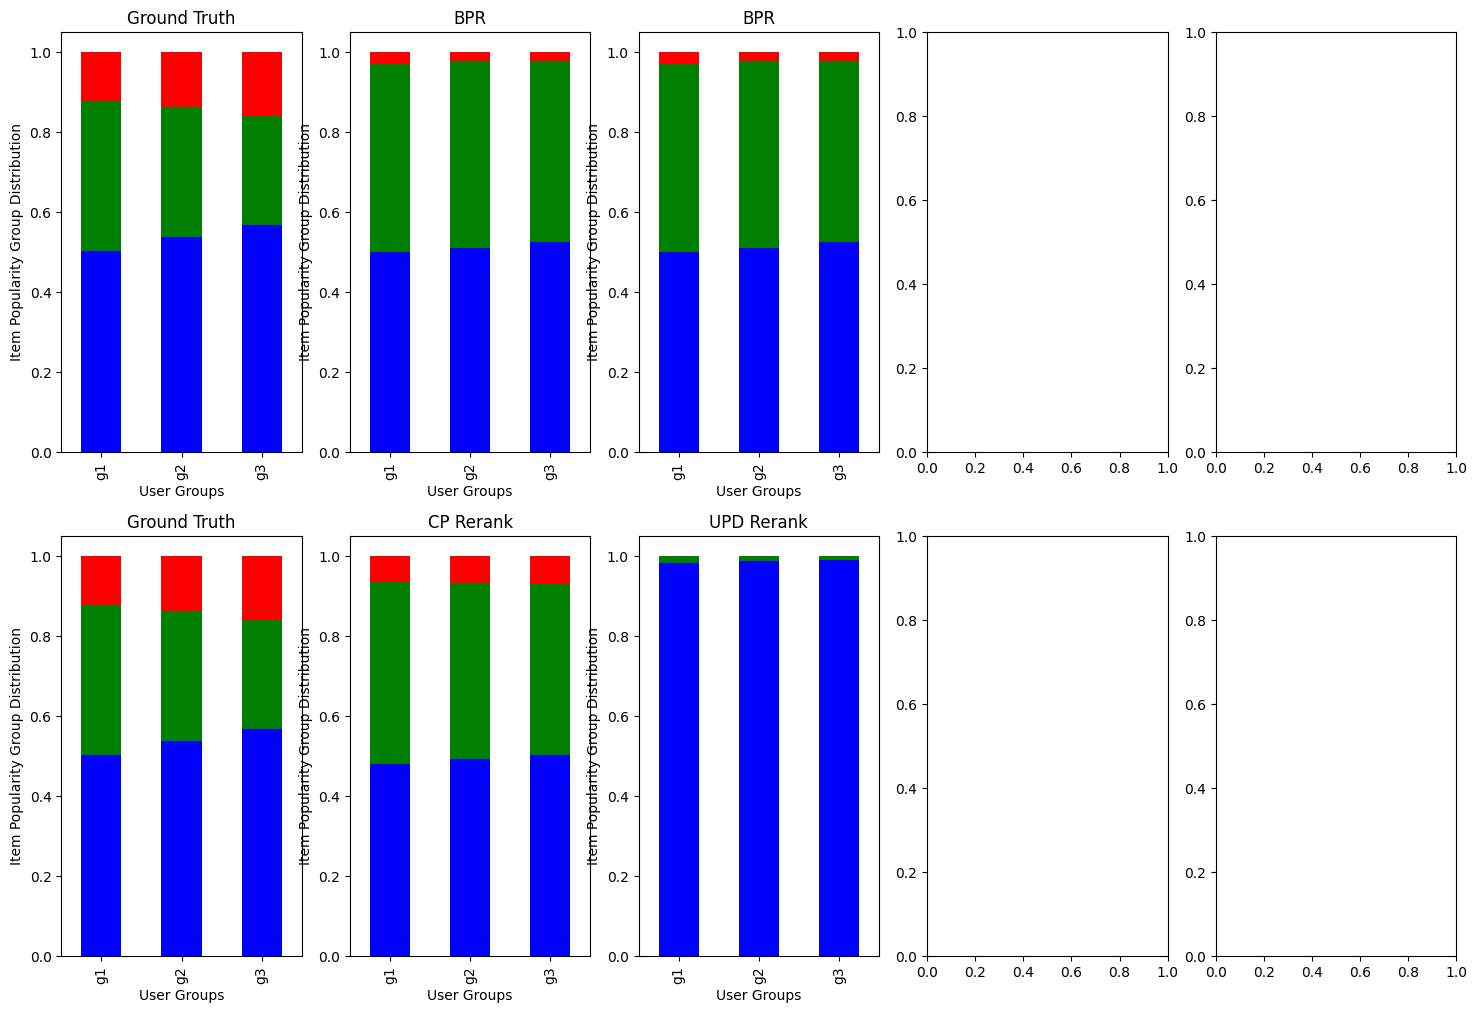

In [308]:

fig, axs = plt.subplots(2, 5, figsize=(18, 12))  # 2 rows, 5 columns

# # Base Models
plot_popularity_distribution(axs[0, 0], train_data, item_popularity, user_groups, "Ground Truth")
plot_popularity_distribution(axs[0, 1], base_eval_general1, item_popularity, user_groups, general_models[0])
plot_popularity_distribution(axs[0, 2], base_eval_general1, item_popularity, user_groups, general_models[0])
# plot_popularity_distribution(axs[0, 2], base_df_general2, item_popularity, user_groups, general_models[1])
# plot_popularity_distribution(axs[0, 3], base_df_context1, item_popularity, user_groups, context_models[0])
# plot_popularity_distribution(axs[0, 4], base_df_context2, item_popularity, user_groups, context_models[1])

# # Calibrated Models
plot_popularity_distribution(axs[1, 0], train_data, item_popularity, user_groups, "Ground Truth")
plot_popularity_distribution(axs[1, 1], reranked_df, item_popularity, user_groups, "CP Rerank")
plot_popularity_distribution(axs[1, 2], calibrated_eval_general1, item_popularity, user_groups, "UPD Rerank")
# plot_popularity_distribution(axs[1, 3], calibrated_df_context1, item_popularity, user_groups, context_models[0])
# plot_popularity_distribution(axs[1, 4], calibrated_df_context2, item_popularity, user_groups, context_models[1])

# fig.suptitle(f"Item-Popularity Distribution for dataset: {dataset}\n base models vs. calibratedred from k={top_k_resample}; cold users/items removed", fontsize=16)

# handles = [plt.Line2D([0], [0], color=color, lw=4) for color in ['blue', 'green', 'red']]
# labels = ['h', 'm', 't']
# fig.legend(handles, labels, title="Item Popularity Groups", loc='upper center', bbox_to_anchor=(0.5, 0.945), ncol=3)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/item_popularity_distribution.png")
# plt.show()

In [263]:
test_data = test_data.merge(item_popularity, on="item_id:token", how="left")

In [304]:
print(f"Dataset: {dataset}")

#base_eval_general1
base_arp_scores, base_poplift_scores, calibrated_arp_scores, calibrated_poplift_scores, base_ndcg_scores, calibrated_ndcg_scores = calculate_deltas(test_data, base_eval_general1, reranked_df, item_popularity, upts, general_models[0])

#base_arp_scores, base_poplift_scores, calibrated_arp_scores, calibrated_poplift_scores, base_ndcg_scores, calibrated_ndcg_scores = calculate_deltas(test_data, base_df_general1, calibrated_df_general1, item_popularity, upts, general_models[0])
#calculate_deltas(test_data, base_df_general2, calibrated_df_general2, item_popularity, upts, general_models[1])
#base_arp_scores, base_poplift_scores, calibrated_arp_scores, calibrated_poplift_scores, base_ndcg_scores, calibrated_ndcg_scores = calculate_deltas(test_data, base_df_context1, calibrated_df_context1, item_popularity, upts, context_models[0])
#base_arp_scores, base_poplift_scores, calibrated_arp_scores, calibrated_poplift_scores, base_ndcg_scores, calibrated_ndcg_scores = calculate_deltas(test_data, base_df_context2, calibrated_df_context2, item_popularity, upts, context_models[1])


#calculate_deltas(test_data, base_df_general1, full_unseen_calibrate_df, item_popularity, upts, f"{general_models[0]} vs. Full Unseen Sort")


Dataset: foursquaretky
      user_id:token item_id:token
0             519_x          56_x
1             519_x           6_x
2             519_x           9_x
3             519_x         966_x
4             519_x        1024_x
...             ...           ...
14995          55_x          20_x
14996          55_x         100_x
14997          55_x         166_x
14998          55_x          97_x
14999          55_x         715_x

[15000 rows x 2 columns]
BPR Base vs. Calibrated Results
Abs. nDCG % change: 10.31%; base: 0.02545; calibrated: 0.02533
Abs. ARP % change : 7.19%; base: 0.01882; calibrated: 0.01676
Abs. Poplift % change : 13.58%; base: -0.41356; calibrated: -0.47867
**************************************************


In [305]:
def evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups):
    group_means = {}
    for group_name, user_ids in user_groups.items():
        group_ndcg_scores = {user_id: ndcg_scores[user_id] for user_id in user_ids if user_id in ndcg_scores}
        group_arp_scores = {user_id: arp_scores[user_id] for user_id in user_ids if user_id in arp_scores}
        group_poplift_scores = {user_id: poplift_scores[user_id] for user_id in user_ids if user_id in poplift_scores}
        
        group_means[group_name] = {
            "ndcg_mean": sum(group_ndcg_scores.values()) / len(group_ndcg_scores),
            "arp_mean": sum(group_arp_scores.values()) / len(group_arp_scores),
            "poplift_mean": sum(group_poplift_scores.values()) / len(group_poplift_scores)
        }
        
        print(f"Group: {group_name} - nDCG: {group_means[group_name]['ndcg_mean']:.5f}; "
              f"ARP: {group_means[group_name]['arp_mean']:.5f}; "
              f"Poplift: {group_means[group_name]['poplift_mean']:.5f}")
    print("*"*50)
    return group_means




In [313]:
user_profiles

user_id:token  mean_pop  median_pop  variance_pop   h_ratio   m_ratio  \
0              0_x  0.019032    0.008916      0.001039  0.439024  0.512195   
1           1000_x  0.014254    0.006241      0.001147  0.281250  0.593750   
2           1001_x  0.021060    0.004993      0.003269  0.263158  0.526316   
3           1002_x  0.015543    0.004636      0.002202  0.236364  0.581818   
4           1003_x  0.018324    0.005884      0.001585  0.369048  0.511905   
...            ...       ...         ...           ...       ...       ...   
1495         997_x  0.009840    0.005528      0.000080  0.272727  0.545455   
1496         998_x  0.021680    0.007311      0.001601  0.416667  0.458333   
1497         999_x  0.010366    0.005706      0.000177  0.266667  0.600000   
1498          99_x  0.020875    0.004280      0.002988  0.232558  0.581395   
1499           9_x  0.016541    0.005706      0.001963  0.222222  0.666667   

       t_ratio  num_interactions  
0     0.048780                41  
1     0.125000                32  
2     0.210526                19  
3     0.181818                55  
4     0.119048                84  
...        ...               ...  
1495  0.181818                22  
1496  0.125000                24  
1497  0.133333                15  
1498  0.186047                43  
1499  0.111111                63  

[1500 rows x 8 columns]

In [311]:
user_groups

{'high': ['10_x',
  '1088_x',
  '49_x',
  '164_x',
  '47_x',
  '646_x',
  '1128_x',
  '453_x',
  '1072_x',
  '336_x',
  '1184_x',
  '1317_x',
  '699_x',
  '502_x',
  '528_x',
  '140_x',
  '578_x',
  '964_x',
  '1123_x',
  '1102_x',
  '817_x',
  '1057_x',
  '801_x',
  '929_x',
  '1412_x',
  '509_x',
  '307_x',
  '684_x',
  '1373_x',
  '1009_x',
  '1063_x',
  '244_x',
  '315_x',
  '416_x',
  '974_x',
  '789_x',
  '156_x',
  '842_x',
  '1104_x',
  '1497_x',
  '1024_x',
  '945_x',
  '1259_x',
  '537_x',
  '291_x',
  '1480_x',
  '941_x',
  '182_x',
  '1078_x',
  '314_x',
  '845_x',
  '71_x',
  '1089_x',
  '1207_x',
  '1035_x',
  '448_x',
  '735_x',
  '1175_x',
  '367_x',
  '1350_x',
  '1318_x',
  '1108_x',
  '1161_x',
  '1058_x',
  '587_x',
  '1099_x',
  '362_x',
  '399_x',
  '73_x',
  '1147_x',
  '565_x',
  '364_x',
  '1368_x',
  '511_x',
  '1295_x',
  '490_x',
  '426_x',
  '680_x',
  '853_x',
  '1055_x',
  '499_x',
  '786_x',
  '52_x',
  '536_x',
  '136_x',
  '444_x',
  '849_x',
  '97_x',

In [314]:
def search_group_lambda(df, user_groups):
    averages = {}
    for group_name, user_ids in user_groups.items():
        group_data = df[df["user_id:token"].isin(user_ids)]
        averages[group_name] = {
            "h_ratio_avg": group_data["h_ratio"].mean(),
            "m_ratio_avg": group_data["m_ratio"].mean(),
            "t_ratio_avg": group_data["t_ratio"].mean()
        }

    # Display results
    for group, stats in averages.items():
        print(f"{group} group averages:")
        for stat, value in stats.items():
            print(f"  {stat}: {value:.4f}")


In [318]:
user_profiles

user_id:token  mean_pop  median_pop  variance_pop   h_ratio   m_ratio  \
0              0_x  0.019032    0.008916      0.001039  0.439024  0.512195   
1           1000_x  0.014254    0.006241      0.001147  0.281250  0.593750   
2           1001_x  0.021060    0.004993      0.003269  0.263158  0.526316   
3           1002_x  0.015543    0.004636      0.002202  0.236364  0.581818   
4           1003_x  0.018324    0.005884      0.001585  0.369048  0.511905   
...            ...       ...         ...           ...       ...       ...   
1495         997_x  0.009840    0.005528      0.000080  0.272727  0.545455   
1496         998_x  0.021680    0.007311      0.001601  0.416667  0.458333   
1497         999_x  0.010366    0.005706      0.000177  0.266667  0.600000   
1498          99_x  0.020875    0.004280      0.002988  0.232558  0.581395   
1499           9_x  0.016541    0.005706      0.001963  0.222222  0.666667   

       t_ratio  num_interactions  
0     0.048780                41  
1     0.125000                32  
2     0.210526                19  
3     0.181818                55  
4     0.119048                84  
...        ...               ...  
1495  0.181818                22  
1496  0.125000                24  
1497  0.133333                15  
1498  0.186047                43  
1499  0.111111                63  

[1500 rows x 8 columns]

In [319]:
search_group_lambda(user_profiles, user_groups)

high group averages:
  h_ratio_avg: 0.3780
  m_ratio_avg: 0.4988
  t_ratio_avg: 0.1232
medium group averages:
  h_ratio_avg: 0.3242
  m_ratio_avg: 0.5374
  t_ratio_avg: 0.1384
low group averages:
  h_ratio_avg: 0.2670
  m_ratio_avg: 0.5722
  t_ratio_avg: 0.1608


In [315]:
search_group_lambda(reranked_df_user, user_groups)

high group averages:
  h_ratio_avg: 0.4547
  m_ratio_avg: 0.4793
  t_ratio_avg: 0.0660
medium group averages:
  h_ratio_avg: 0.4401
  m_ratio_avg: 0.4929
  t_ratio_avg: 0.0670
low group averages:
  h_ratio_avg: 0.4283
  m_ratio_avg: 0.5017
  t_ratio_avg: 0.0700


In [323]:
base_eval = calculate_user_popularity_distributions(base_eval_general1, item_popularity)

In [342]:
search_group_lambda(base_eval, user_groups)

high group averages:
  h_ratio_avg: 0.5007
  m_ratio_avg: 0.4697
  t_ratio_avg: 0.0297
medium group averages:
  h_ratio_avg: 0.5103
  m_ratio_avg: 0.4661
  t_ratio_avg: 0.0236
low group averages:
  h_ratio_avg: 0.5257
  m_ratio_avg: 0.4513
  t_ratio_avg: 0.0230


In [307]:
print("BASE")
group_means = evaluation_user_group_means(base_ndcg_scores, base_arp_scores, base_poplift_scores, user_groups)
print("RE_RANKED")
group_means = evaluation_user_group_means(calibrated_ndcg_scores, calibrated_arp_scores, calibrated_poplift_scores, user_groups)

BASE
Group: high - nDCG: 0.02095; ARP: 0.01854; Poplift: -0.43503
Group: medium - nDCG: 0.03030; ARP: 0.01882; Poplift: -0.41881
Group: low - nDCG: 0.01538; ARP: 0.01912; Poplift: -0.37636
**************************************************
RE_RANKED
Group: high - nDCG: 0.02081; ARP: 0.01699; Poplift: -0.47558
Group: medium - nDCG: 0.02989; ARP: 0.01684; Poplift: -0.48167
Group: low - nDCG: 0.01616; ARP: 0.01630; Poplift: -0.47278
**************************************************


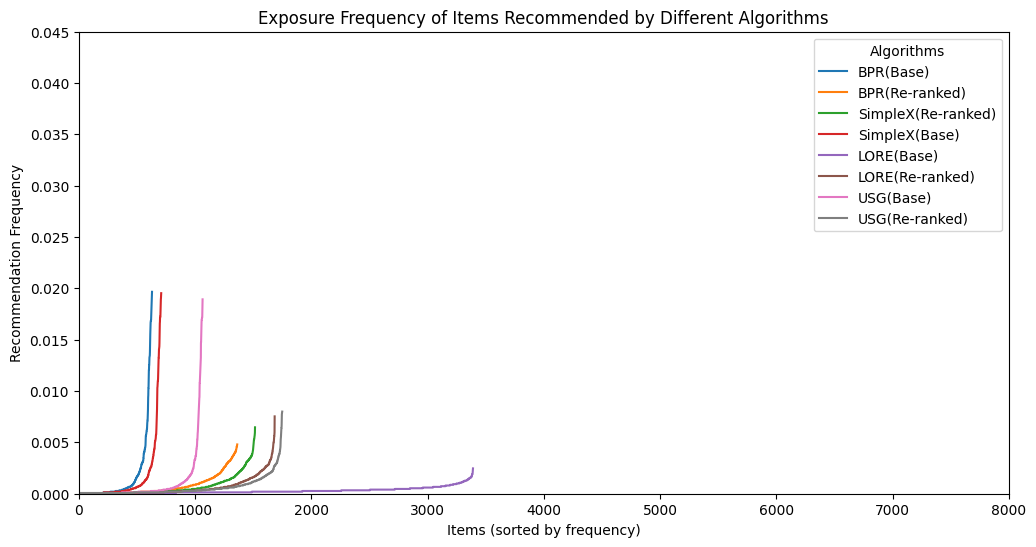

In [ ]:

# List of algorithm DataFrames and their names
algorithm_dfs = {
    'BPR(Base)': base_df_general1,
    'BPR(Re-ranked)': calibrated_df_general1,
    'SimpleX(Re-ranked)': calibrated_df_general2,
    'SimpleX(Base)': base_df_general2,
    'LORE(Base)': base_df_context1,
    'LORE(Re-ranked)': calibrated_df_context1,
    'USG(Base)': base_df_context2,
    'USG(Re-ranked)': calibrated_df_context2
}

# Dictionary to store sorted frequencies for each algorithm
item_frequencies = {}

# Calculate frequency of each item in recommendations for each algorithm
for algorithm_name, df in algorithm_dfs.items():
    # Count item frequencies in each DataFrame
    item_counts = df['item_id:token'].value_counts(normalize=True)  # Normalize to get frequency
    sorted_counts = item_counts.sort_values(ascending=True).values  # Sort in descending order
    item_frequencies[algorithm_name] = sorted_counts  # Store sorted frequencies

# Plotting
plt.figure(figsize=(12, 6))

# Plot each algorithm's sorted item frequencies
for algorithm_name, frequencies in item_frequencies.items():
    plt.plot(frequencies, label=algorithm_name)

plt.xlabel('Items (sorted by frequency)')
plt.ylabel('Recommendation Frequency')
plt.title('Exposure Frequency of Items Recommended by Different Algorithms')
plt.legend(title='Algorithms')
plt.ylim(0, 0.045)  # Adjust as needed based on frequency range
plt.xlim(0, 8000)  # Adjust as needed based on frequency range
plt.show()


## Look more fine-grained at evaluation of specific user id

In [ ]:

user_id = "311_x"

print(f"Base NDCG for user {user_id}: {base_ndcg_scores[user_id]}, Calibrated score: {calibrated_ndcg_scores[user_id]}")
print(f"Base ARP for user {user_id}: {base_arp_scores[user_id]}, Calibrated ARP: {calibrated_arp_scores[user_id]}")
print(f"Base Poplift for {user_id}: {base_poplift_scores[user_id]}, Calibrated Poplift: {calibrated_poplift_scores[user_id]}")

Base NDCG for user 311_x: 0, Calibrated score: 0
Base ARP for user 311_x: 0.11826086956521735, Calibrated ARP: 0.05739130434782604
Base Poplift for 311_x: 1.033644859813085, Calibrated Poplift: -0.013084112149532716


In [ ]:
def open_context_info():
      # Stays the same across all models 
    # train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/{dataset}_sample.train.inter", sep="\t")
    # test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset//{dataset}_sample.test.inter", sep="\t")
    # valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/{dataset}_sample.valid.inter", sep="\t")
    item_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.item", sep="\t")
    # #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    # train_data = pd.concat([train_data, valid_data])



    return item_data #,user_groups

In [ ]:
item_data = open_context_info()

In [ ]:
advanced_users = list(train_data.loc[train_data["item_id:token"] == "128_x"]["user_id:token"])
#user_id = advanced_users[0]

In [ ]:
def specific_user_rec_sampler(df, user_id, item_data=item_data):

    user_recs = df.loc[df['user_id:token'] == user_id]

    #user_recs = base_df_general1.loc[base_df_general1['user_id:token'] == user_id]
    user_recs = user_recs.merge(item_data, on="item_id:token", how="left")
    return user_recs

In [ ]:
user_recs = specific_user_rec_sampler(base_df_context1, user_id)

In [ ]:
import folium

def make_map(df):
    map_center = [df['lat:float'].mean(), df['lon:float'].mean()]
    map = folium.Map(location=map_center, zoom_start=5)

    # Add markers for each location
    for _, row in df.iterrows():
        folium.Marker(
            location=[row['lat:float'], row['lon:float']],
            popup=row['item_id:token'],
            tooltip=row['item_id:token']
        ).add_to(map)

    return map

In [ ]:
user_ground_truth = train_data.loc[train_data['user_id:token'] == user_id].merge(item_data, on="item_id:token", how="left")

In [ ]:
item_popularity

item_id:token  business_popularity:float item_pop_group
30546        1020_x                   1.000000              h
2491          730_x                   0.926087              h
24326         212_x                   0.769565              h
1357          549_x                   0.721739              h
13510          46_x                   0.695652              h
...             ...                        ...            ...
14628        3821_x                   0.043478              t
7016         2809_x                   0.043478              t
24909        4048_x                   0.043478              t
25023         429_x                   0.043478              t
21046        4166_x                   0.043478              t

[4510 rows x 3 columns]

In [ ]:
user_recs.merge(item_popularity, on="item_id:token", how="left")

user_id:token item_id:token                name:token_seq  lat:float  \
0         311_x        2609_x             Monsoon Chocolate  32.206491   
1         311_x        2111_x          American Eat Company  32.203908   
2         311_x        1722_x                  Roma Imports  32.214239   
3         311_x        1302_x                 Welcome Diner  32.220974   
4         311_x        1094_x  5 Points Market & Restaurant  32.212200   
5         311_x        2052_x          Mi Nidito Restaurant  32.199964   
6         311_x        1510_x              Insomnia Cookies  32.221883   
7         311_x        1511_x                    Urban Pita  32.221883   
8         311_x          61_x          OBON Sushi Bar Ramen  32.221800   
9         311_x         847_x        Charro Steak & Del Rey  32.221077   

    lon:float                            category_name:token_seq  \
0 -110.965960   Themed Cafes, Desserts, Cafes, Restaurants, Food   
1 -110.965138  Coffee & Tea, Beer, Wine & Spirits, Grocery, F...   
2 -110.948824  Cheese Shops, Delis, Specialty Food, Restauran...   
3 -110.957513  Restaurants, Nightlife, Comfort Food, Cocktail...   
4 -110.969090  Restaurants, American (New), Delis, Vegetarian...   
5 -110.965150  Restaurants, Mexican, Desserts, Food, Latin Am...   
6 -110.965287  Ice Cream & Frozen Yogurt, Desserts, Food Deli...   
7 -110.965623  Middle Eastern, Restaurants, Greek, Falafel, F...   
8 -110.965922  Sushi Bars, Restaurants, Bars, Japanese, Ramen...   
9 -110.967255          Diners, Restaurants, Steakhouses, Mexican   

   business_popularity:float item_pop_group  
0                   0.073913              m  
1                   0.160870              h  
2                   0.047826              t  
3                   0.165217              h  
4                   0.121739              m  
5                   0.060870              m  
6                   0.043478              t  
7                   0.043478              t  
8                   0.108696              m  
9                   0.069565              m

In [ ]:
item_data.loc[item_data["item_id:token"] == "164_x"]

item_id:token               name:token_seq  lat:float  lon:float  \
1892         164_x  Ronnie's Marcus Imax Cinema  38.527293 -90.362332   

           category_name:token_seq  
1892  Arts & Entertainment, Cinema

In [ ]:
map = make_map(item_data)

In [ ]:
item_data["category_name:token_seq"].values.tolist()

['Sushi Bars, Restaurants, Japanese',
 'Korean, Restaurants',
 'Restaurants, Italian',
 'Eatertainment, Arts & Entertainment, Brewpubs, American (Traditional), Bakeries, Breweries, Food, Restaurants',
 'Sports Bars, American (New), American (Traditional), Nightlife, Bars, Restaurants',
 'Food, Beer, Wine & Spirits, Breweries',
 'Nightlife, Pubs, Event Planning & Services, Wine Bars, Bars, Gastropubs, Restaurants, Venues & Event Spaces',
 'Ice Cream & Frozen Yogurt, Coffee & Tea, Restaurants, Sandwiches, Food',
 'Restaurants, Seafood, Cajun/Creole',
 'Bars, Beer Gardens, Food, Breweries, Nightlife, Tours, Pubs, Wine Tours, Beer Tours, Hotels & Travel',
 'Venues & Event Spaces, Performing Arts, Arts & Entertainment, Hotels & Travel, Food, Convenience Stores, American (New), Beauty & Spas, Restaurants, Museums, Event Planning & Services, Hotels, Cinema, Resorts, Day Spas',
 'Steakhouses, Restaurants, Sushi Bars, Japanese',
 'Restaurants, Salad, Pakistani, Indian, Cocktail Bars, Food, Food

In [ ]:
# map

In [ ]:
# group_deltas_general1 = delta_ndcg_scores_by_group(test_data, base_df_general1, calibrated_df_general1, user_groups)
# group_deltas_general2 = delta_ndcg_scores_by_group(test_data, base_df_general2, calibrated_df_general2, user_groups)
# group_deltas_context1 = delta_ndcg_scores_by_group(test_data, base_df_context1, calibrated_df_context1, user_groups)
# group_deltas_context2 = delta_ndcg_scores_by_group(test_data, base_df_context2, calibrated_df_context2, user_groups)

In [ ]:
item_data.nunique()

item_id:token              4510
name:token_seq             4039
lat:float                  4461
lon:float                  4446
category_name:token_seq    3955
dtype: int64